In [120]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Fetch data
url = "http://127.0.0.1:8000/api/v1/data/?table_name=precios_materiales&limit=1000"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(f"✓ Successfully fetched {len(data['data'])} records")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}") 
    raise
# Convert to Data Frame
df = pd.DataFrame(data['data'])

#Convert date to date of Dataframe
df['date'] = pd.to_datetime(df['date'])


#Variable a analizar 
var_analizar = 'scrap_mxn'

#https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm




✓ Successfully fetched 190 records


# Modelo LSTM para Pronóstico de Series de Tiempo

Ahora aplicaremos una Red Neuronal LSTM (Long Short-Term Memory) para pronosticar el precio del scrap.


In [121]:
# Importar librerías necesarias para LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM , Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


## Paso 1: Preparar los datos para LSTM

Los datos deben ser:
1. Normalizados (escalados entre 0 y 1)
2. Convertidos a secuencias (ventanas de tiempo)


In [122]:
# Preparar los datos para LSTM
# Convertir la serie a un array numpy y reshape para el scaler
serie = df[var_analizar]
data_array = serie.values.reshape(-1, 1)

# Normalizar los datos (escalar entre 0 y 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_array)

print(f"Datos originales - Min: {data_array.min():.2f}, Max: {data_array.max():.2f}")
print(f"Datos escalados - Min: {data_scaled.min():.2f}, Max: {data_scaled.max():.2f}")
print(f"Shape de datos escalados: {data_scaled.shape}")


Datos originales - Min: 6034.54, Max: 13506.30
Datos escalados - Min: 0.00, Max: 1.00
Shape de datos escalados: (190, 1)


In [123]:
# Función para crear secuencias de datos para LSTM
def create_sequences(data, seq_length):
    """
    Crea secuencias de datos para LSTM
    
    Args:
        data: Array de datos escalados
        seq_length: Longitud de la ventana de tiempo (número de pasos hacia atrás)
    
    Returns:
        X: Features (secuencias de datos históricos)
        y: Target (valor siguiente)
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Definir la longitud de la secuencia (ventana de tiempo)
# Usaremos 30 días de historia para predecir el siguiente día
sequence_length = 20

# Crear secuencias
X, y = create_sequences(data_scaled, sequence_length)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nEjemplo de una secuencia X[0]: {X[0][:5]}... (primeros 5 valores)")
print(f"Valor objetivo y[0]: {y[0]}")


Shape de X (features): (170, 20)
Shape de y (target): (170,)

Ejemplo de una secuencia X[0]: [0.46625695 0.46187712 0.48967847 0.50011778 0.58180536]... (primeros 5 valores)
Valor objetivo y[0]: 0.4613538175744404


## Paso 2: Dividir en conjunto de entrenamiento y prueba


In [124]:
# Dividir los datos en entrenamiento (80%) y prueba (20%)
# Usar shuffle=False para mantener el orden temporal
split_index = int(len(X) * 0.78)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Conjunto de entrenamiento - X: {X_train.shape}, y: {y_train.shape}")
print(f"Conjunto de prueba - X: {X_test.shape}, y: {y_test.shape}")

# Reshape para LSTM: (muestras, timesteps, características)
# LSTM requiere datos en formato 3D: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"\nDespués del reshape para LSTM:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")


Conjunto de entrenamiento - X: (132, 20), y: (132,)
Conjunto de prueba - X: (38, 20), y: (38,)

Después del reshape para LSTM:
X_train: (132, 20, 1)
X_test: (38, 20, 1)


## Paso 3: Construir y compilar el modelo LSTM


In [125]:
# Construir el modelo LSTM
model = Sequential([
    # Primera capa LSTM con return_sequences=True para apilar más capas
    LSTM(2000, activation='tanh', return_sequences=False, input_shape=(sequence_length, 1)),
    Dropout(0.2),  # Regularización para evitar overfitting
    
    # Segunda capa LSTM
    # LSTM(5000, activation='relu', return_sequences=False),
    # Dropout(0.2),
    
    # Capa densa de salida
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar la arquitectura del modelo
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 2000)           │    16,016,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         2,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,018,001 (61.10 MB)

 Trainable params: 16,018,001 (61.10 MB)

 Non-trainable params: 0 (0.00 B)

## Paso 4: Entrenar el modelo


In [126]:
# Configurar early stopping para evitar sobreentrenamiento
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenar el modelos
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # Usar 20% del train para validación
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - loss: 0.0356 - mae: 0.1506 - val_loss: 0.0133 - val_mae: 0.1118
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - loss: 0.0104 - mae: 0.0780 - val_loss: 0.0039 - val_mae: 0.0573
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - loss: 0.0061 - mae: 0.0599 - val_loss: 0.0036 - val_mae: 0.0534
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - loss: 0.0043 - mae: 0.0540 - val_loss: 0.0013 - val_mae: 0.0290
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - loss: 0.0048 - mae: 0.0567 - val_loss: 8.6662e-04 - val_mae: 0.0245
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.0044 - mae: 0.0551 - val_loss: 7.3497e-04 - val_mae: 0.0227
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.0042 - mae: 0.0542 - val_loss: 0.0013 - val_mae: 0.0312
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.0043 - mae: 0.0534 - val_loss: 0.0011 - val_mae: 0.0288
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - los

## Paso 5: Visualizar el entrenamiento


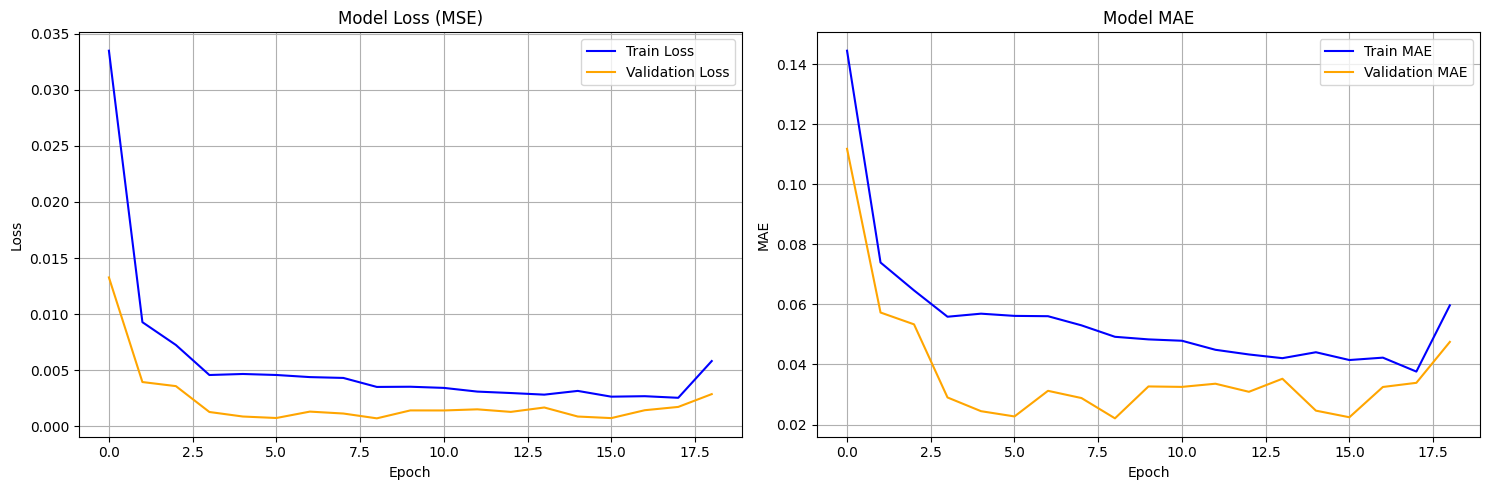

In [127]:
# Graficar la pérdida durante el entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida (Loss)
axes[0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
axes[0].set_title('Model Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Error absoluto medio (MAE)
axes[1].plot(history.history['mae'], label='Train MAE', color='blue')
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='orange')
axes[1].set_title('Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Ambas metricas MSE y MAE muestran disminucio rapida en las primeras 5 epocas, indicando que el modelo esta aprendiendo efectivamente los patrones de los datos.

Despues del epoch 7 ambas curbas se estabilizan, sugiriendo que el modelo ha alcanzado su capacidad de aprendizaje optima



## Paso 6: Hacer predicciones


In [128]:
# Hacer predicciones en el conjunto de prueba
y_pred_scaled = model.predict(X_test, verbose=0)

# Desnormalizar las predicciones
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"Predicciones escaladas shape: {y_pred_scaled.shape}")
print(f"Predicciones originales shape: {y_pred.shape}")
print(f"\nPrimeras 5 predicciones:")
print(f"Predicciones: {y_pred[:5].flatten()}")
print(f"Valores reales: {y_test_original[:5].flatten()}")


Predicciones escaladas shape: (38, 1)
Predicciones originales shape: (38, 1)

Primeras 5 predicciones:
Predicciones: [7233.3457 7171.981  7125.464  7098.965  7077.3516]
Valores reales: [6824.22 6921.28 6897.2  6966.33 7144.83]


## Paso 7: Evaluar el modelo


In [129]:
# Calcular métricas de evaluación
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred)

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

print("Métricas de Evaluación:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Métricas de Evaluación:
Mean Squared Error (MSE): 113686.77
Root Mean Squared Error (RMSE): 337.17
Mean Absolute Error (MAE): 301.89
Mean Absolute Percentage Error (MAPE): 4.45%


## Paso 8: Visualizar resultados


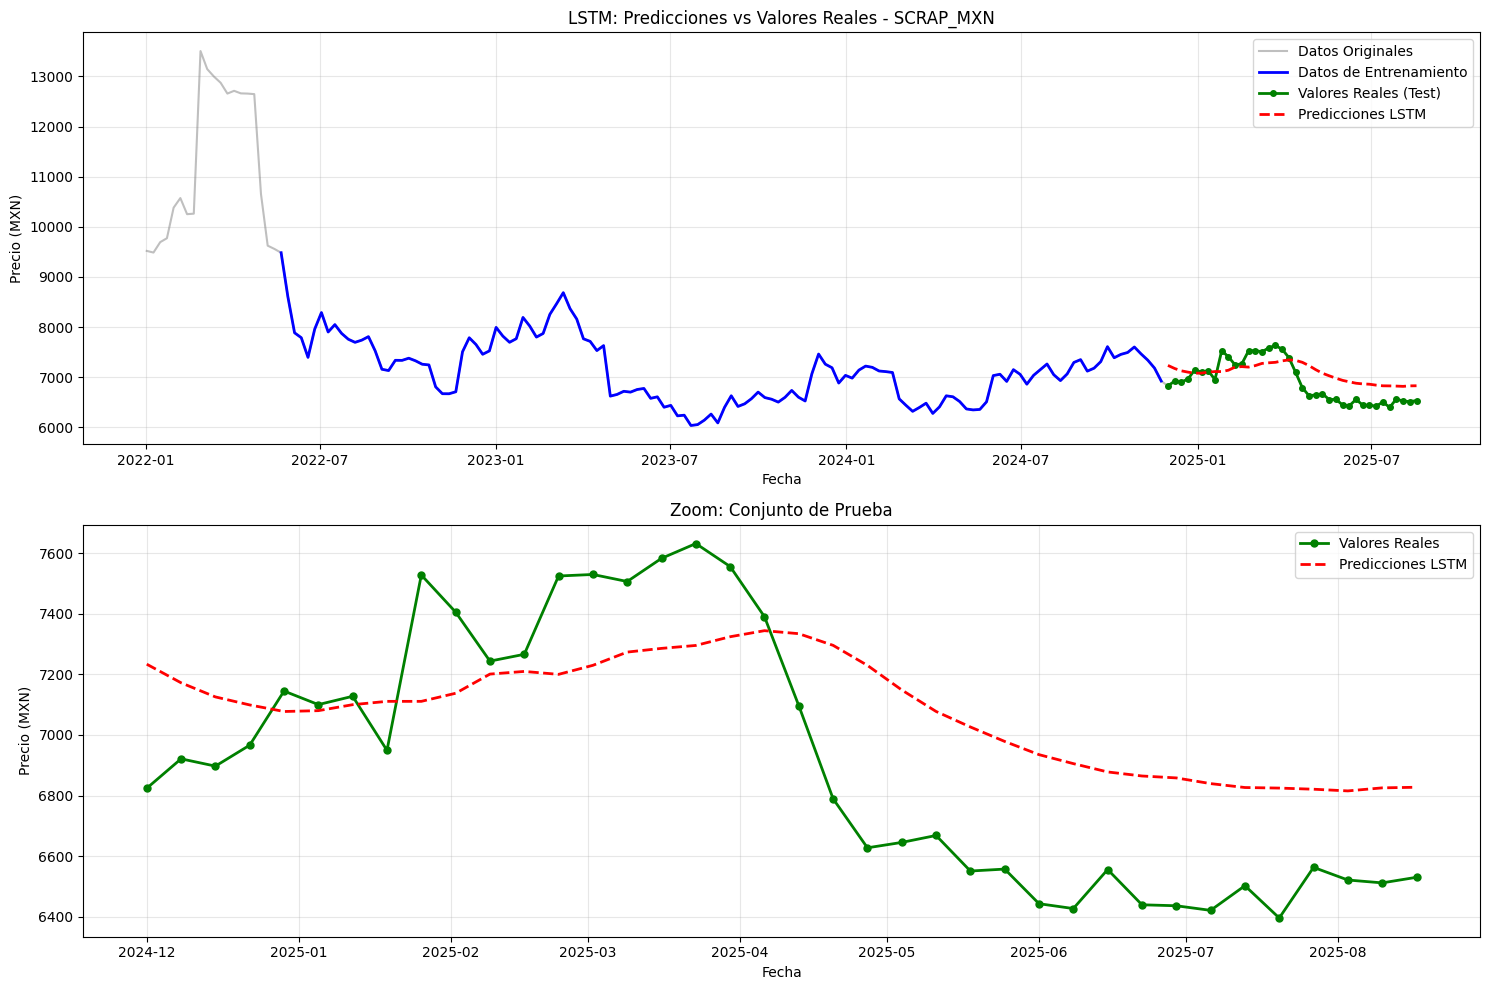

In [130]:
# Obtener los índices de fechas correspondientes
# Ajustar los índices ya que perdimos los primeros 'sequence_length' puntos al crear secuencias
train_indices = df['date'][sequence_length:split_index + sequence_length].values
test_indices = df['date'][split_index + sequence_length:].values

# Asegurarse de que los índices coincidan con las predicciones
min_len = min(len(test_indices), len(y_pred))
test_indices = test_indices[:min_len]
y_pred_plot = y_pred[:min_len].flatten()
y_test_plot = y_test_original[:min_len].flatten()

# Graficar resultados
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico completo con train, test y predicciones
axes[0].plot(df['date'], serie.values, label='Datos Originales', color='gray', alpha=0.5)
axes[0].plot(train_indices, scaler.inverse_transform(y_train.reshape(-1, 1)).flatten(), 
             label='Datos de Entrenamiento', color='blue', linewidth=2)
axes[0].plot(test_indices, y_test_plot, label='Valores Reales (Test)', 
             color='green', linewidth=2, marker='o', markersize=4)
axes[0].plot(test_indices, y_pred_plot, label='Predicciones LSTM', 
             color='red', linewidth=2,  linestyle='--')
axes[0].set_title(f'LSTM: Predicciones vs Valores Reales - {var_analizar.upper()}')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Precio (MXN)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de zoom en el conjunto de prueba
axes[1].plot(test_indices, y_test_plot, label='Valores Reales', 
             color='green', linewidth=2, marker='o', markersize=5)
axes[1].plot(test_indices, y_pred_plot, label='Predicciones LSTM', 
             color='red', linewidth=2,  linestyle='--')
axes[1].set_title('Zoom: Conjunto de Prueba')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Precio (MXN)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


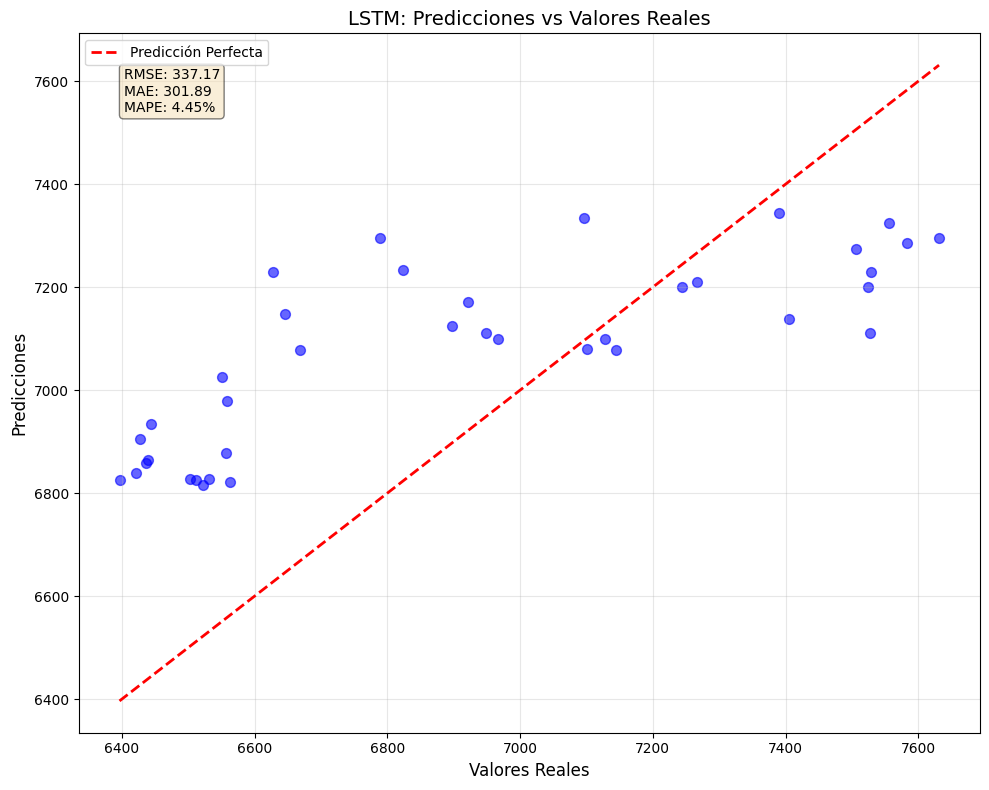

In [131]:
# Gráfico de dispersión: Predicciones vs Valores Reales
plt.figure(figsize=(10, 8))
plt.scatter(y_test_plot, y_pred_plot, alpha=0.6, color='blue', s=50)
plt.plot([y_test_plot.min(), y_test_plot.max()], 
         [y_test_plot.min(), y_test_plot.max()], 
         'r--', lw=2, label='Predicción Perfecta')
plt.xlabel('Valores Reales', fontsize=12)
plt.ylabel('Predicciones', fontsize=12)
plt.title('LSTM: Predicciones vs Valores Reales', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Agregar texto con métricas
textstr = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nMAPE: {mape:.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


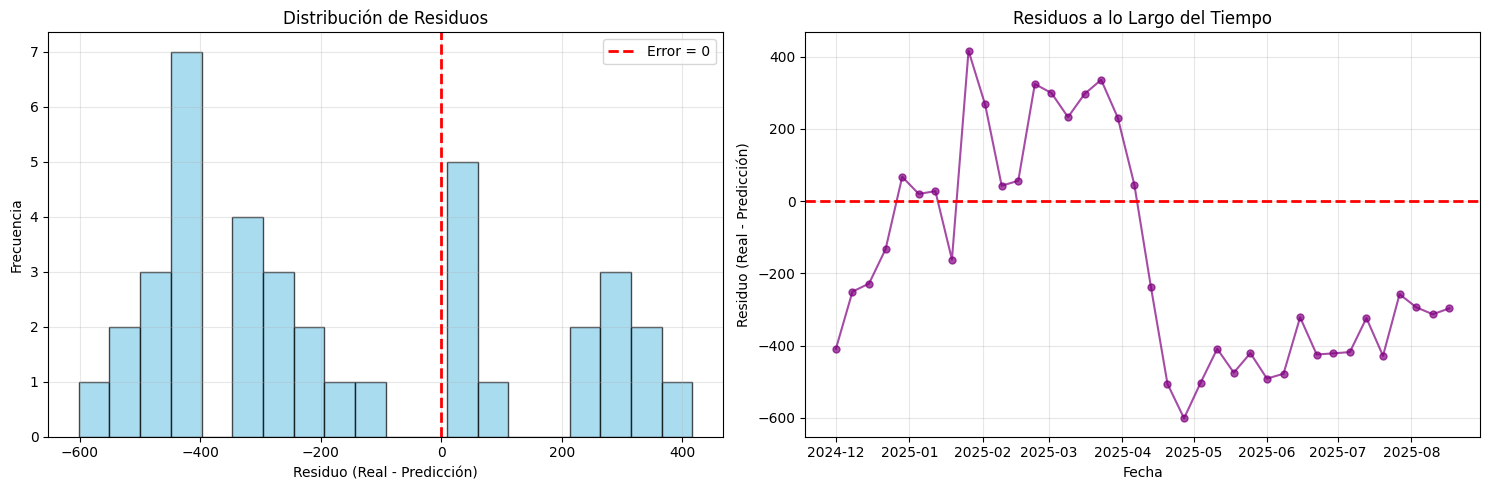


Estadísticas de los Residuos:
Media: -161.57
Desviación Estándar: 295.94
Min: -601.63
Max: 416.71


In [132]:
# Gráfico de errores residuales
residuals = y_test_plot - y_pred_plot

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma de residuos
axes[0].hist(residuals, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[0].set_title('Distribución de Residuos')
axes[0].set_xlabel('Residuo (Real - Predicción)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuos a lo largo del tiempo
axes[1].plot(test_indices, residuals, marker='o', markersize=5, color='purple', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Residuos a lo Largo del Tiempo')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Residuo (Real - Predicción)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEstadísticas de los Residuos:")
print(f"Media: {residuals.mean():.2f}")
print(f"Desviación Estándar: {residuals.std():.2f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")


## Paso 9: Predicciones futuras

Ahora podemos usar el modelo entrenado para hacer predicciones futuras.


In [133]:
def forecast_future(model, last_sequence, n_steps, scaler):
    """
    Realiza predicciones futuras usando el modelo LSTM entrenado
    
    Args:
        model: Modelo LSTM entrenado
        last_sequence: Última secuencia de datos (últimos sequence_length valores)
        n_steps: Número de pasos futuros a predecir
        scaler: Scaler usado para normalizar los datos
    
    Returns:
        predictions: Array con las predicciones futuras (desnormalizadas)
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Reshape para el modelo: (1, sequence_length, 1)
        current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))
        
        # Hacer predicción
        next_pred = model.predict(current_sequence_reshaped, verbose=0)
        predictions.append(next_pred[0, 0])
        
        # Actualizar la secuencia: agregar la predicción y eliminar el primer valor
        current_sequence = np.append(current_sequence[1:], next_pred[0, 0])
    
    # Desnormalizar predicciones
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()

# Usar los últimos 'sequence_length' valores para hacer predicciones futuras
last_sequence_scaled = data_scaled[-sequence_length:].flatten()

# Predecir los próximos 30 días
n_future_steps = 30
future_predictions = forecast_future(model, last_sequence_scaled, n_future_steps, scaler)

print(f"Predicciones para los próximos {n_future_steps} días:")
print(f"Primeros 5 valores: {future_predictions[:5]}")
print(f"Últimos 5 valores: {future_predictions[-5:]}")


Predicciones para los próximos 30 días:
Primeros 5 valores: [6827.353  6851.128  6895.942  6925.1543 6951.2856]
Últimos 5 valores: [7147.781  7149.473  7150.9463 7152.2383 7153.3726]


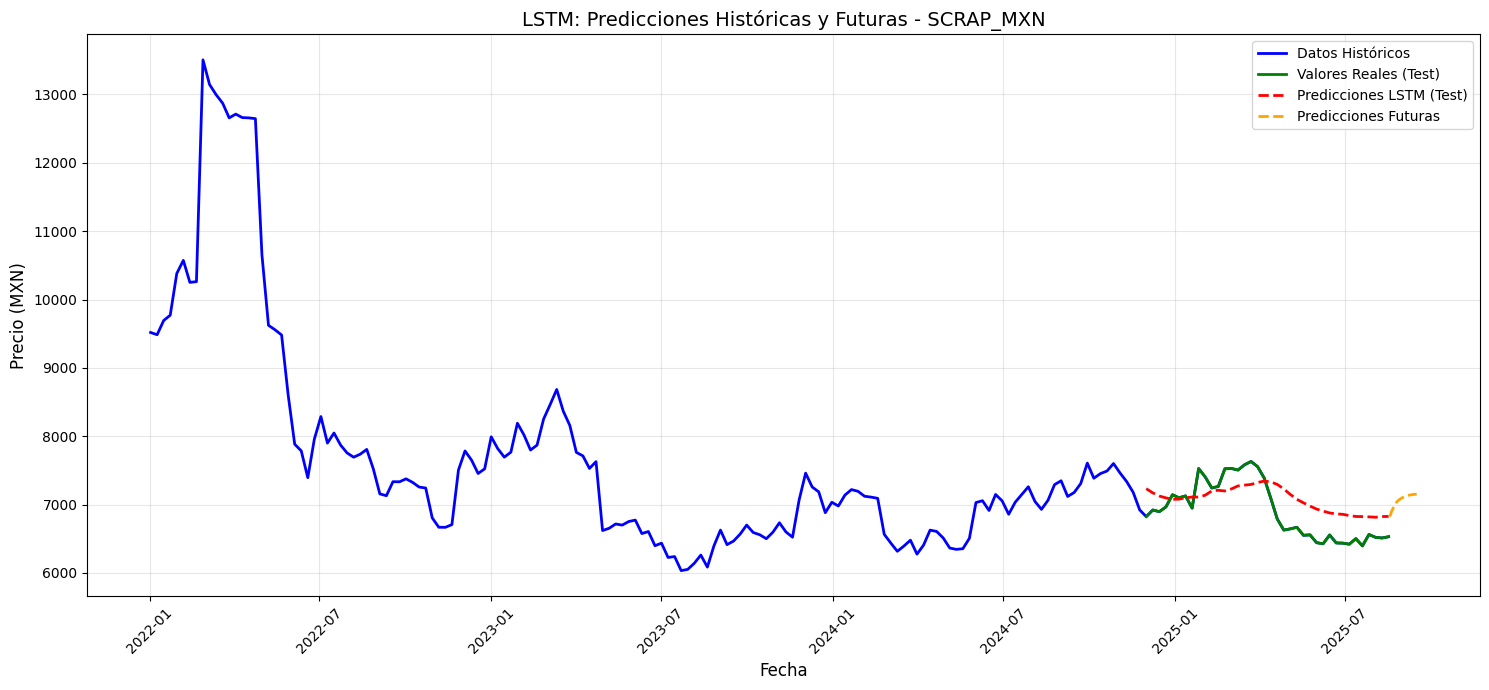

In [134]:
# Crear fechas futuras para las predicciones
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_steps, freq='D')

# Graficar datos históricos y predicciones futuras
plt.figure(figsize=(15, 7))

# Datos históricos
plt.plot(df['date'], serie.values, label='Datos Históricos', color='blue', linewidth=2)

# Conjunto de prueba y predicciones
plt.plot(test_indices, y_test_plot, label='Valores Reales (Test)', 
         color='green', linewidth=2,  markersize=4)
plt.plot(test_indices, y_pred_plot, label='Predicciones LSTM (Test)', 
         color='red', linewidth=2,  markersize=4, linestyle='--')

# Predicciones futuras
plt.plot(future_dates, future_predictions, label='Predicciones Futuras', 
         color='orange', linewidth=2,  markersize=5, linestyle='--')

#plt.axvline(x=last_date, color='gray', linestyle=':', linewidth=2, label='Inicio de Predicciones Futuras')

plt.title(f'LSTM: Predicciones Históricas y Futuras - {var_analizar.upper()}', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (MXN)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Diagrama de Flujo del Proceso LSTM

```mermaid
flowchart TD
    A[Inicio: Cargar Datos] --> B[Fetch desde API REST<br/>precios_materiales]
    B --> C{¿Datos<br/>cargados?}
    C -->|Error| B
    C -->|Éxito| D[Convertir a DataFrame]
    D --> E[Convertir columna date<br/>a datetime]
    E --> F[Seleccionar variable<br/>scrap_mxn]
    
    F --> G[Importar Librerías<br/>TensorFlow/Keras<br/>sklearn<br/>numpy/pandas]
    
    G --> H[Preparar Datos]
    H --> I[Convertir serie a array numpy<br/>reshape -1, 1]
    I --> J[Normalizar datos<br/>MinMaxScaler 0-1]
    J --> K[Crear secuencias<br/>ventana: 30 días]
    K --> L[create_sequences<br/>X: features<br/>y: target]
    
    L --> M[División Train/Test<br/>80% / 20%<br/>sin shuffle]
    M --> N[Reshape para LSTM<br/>3D: samples, timesteps, features]
    
    N --> O[Construir Modelo LSTM]
    O --> P[Capa LSTM 1<br/>50 unidades<br/>return_sequences=True]
    P --> Q[Dropout 0.2]
    Q --> R[Capa LSTM 2<br/>50 unidades<br/>return_sequences=False]
    R --> S[Dropout 0.2]
    S --> T[Capa Dense<br/>1 unidad salida]
    
    T --> U[Compilar Modelo<br/>optimizer: adam<br/>loss: mse<br/>metrics: mae]
    
    U --> V[Configurar Early Stopping<br/>monitor: val_loss<br/>patience: 10]
    V --> W[Entrenar Modelo<br/>epochs: 100<br/>batch_size: 32<br/>validation_split: 0.2]
    
    W --> X{¿Early<br/>Stopping?}
    X -->|Sí| Y[Restaurar mejores pesos]
    X -->|No| W
    
    Y --> Z[Visualizar Entrenamiento<br/>Loss y MAE<br/>Train vs Validation]
    
    Z --> AA[Hacer Predicciones<br/>model.predict X_test]
    AA --> AB[Desnormalizar Predicciones<br/>inverse_transform]
    
    AB --> AC[Evaluar Modelo]
    AC --> AD[Calcular Métricas<br/>MSE<br/>RMSE<br/>MAE<br/>MAPE]
    
    AD --> AE[Visualizar Resultados]
    AE --> AF[Gráfico 1: Comparación<br/>Train/Test/Predicciones]
    AF --> AG[Gráfico 2: Zoom Test Set]
    AG --> AH[Gráfico 3: Dispersión<br/>Real vs Predicción]
    AH --> AI[Gráfico 4: Análisis Residuales<br/>Histograma y Temporal]
    
    AI --> AJ[Predicciones Futuras]
    AJ --> AK[forecast_future<br/>últimos 30 valores<br/>predecir 30 días]
    AK --> AL[Crear fechas futuras<br/>pd.date_range]
    AL --> AM[Visualizar Predicciones<br/>Histórico + Futuro]
    
    AM --> END[Fin]
    
    style A fill:#e1f5ff
    style END fill:#ffe1f5
    style O fill:#fff4e1
    style W fill:#e1ffe1
    style AC fill:#f4e1ff
    style AJ fill:#ffe1e1
```
